In [1]:
import numpy as np
import pandas as pd
from timeit import timeit, repeat
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import gamma
from IPython.display import Latex

## 1. Compare Householder & Givens in QR decomposition
### (a) Complexity Analysis
All analysises are based on algorithms in next two sections, so you may read them first.
Notation: times of addition and subtraction: "AS", times of multiplication and division: "MD".

**Householder method.**

The main contribution to complexity is from the renewing of Q and R.

In k-th iteration, you do following computations: (We only consider those contribute to the "leading term", which is $O(n^2)$)

- renew Q
    - <code>Q[:,k:] * v</code> AS and MP: $n(n-k)$.
    - <code>[a (n-k)-dim vector] * v.T</code> AS and MP: $(n-k)^2$.
    - <code>[a n*(n-k) matrix] * (2 / np.linalg.norm(v) ** 2)</code> MP: $n(n-k)$.
    - <code>Q[:,k:] -= [a n*(n-k) matrix]</code> AS: $n(n-k)$.
    
- renew R
    - <code>v.T * R[k:,k:]</code> AS and MP: $(n-k)^2$.
    - <code>v * [a (n-k)-dim vector]</code> AS and MP: $(n-k)^2$.
    - <code>[a (n-k)*(n-k) matrix] * (2 / np.linalg.norm(v) ** 2)</code> MP: $(n-k)^2$.
    - <code>R[k:,k:] -= [a (n-k)*(n-k) matrix]</code> AS: $(n-k)^2$.
    
In total, AS and MP: $4(n-k)^2+2n(n-k)$. And for all iterations, AS and MP: $\sum_{k=0}^{n-1}4(n-k)^2+2n(n-k)\approx\frac{14}{3}n^3\approx4.7n^3$, respectively.

**Givens rotation.**

The main contribution to complexity is also from the renewing of Q and R.

In the iteration labelled by k, m, you do following computations:

- renew Q <code>Q[-(k+2): , n-2-k+m:n-k+m] * GI</code> AS and MP: $4(n-k)$.
    
- renew R <code>G * R[n-2-k+m:n-k+m , m:]</code> AS and MP: $4(n-m)$.
    
In total, AS and MP: $4(2n-k-m)$. And for all iterations, AS and MP: $\sum_{k=0}^{n-1}\sum_{m=0}^{k+1}\approx4\sum_{k=0}^{n-1}2nk-\frac{3}{2}k^2\approx2n^3$, respectively.

### (b) QR decomposition using Householder transformation

In [2]:
def householder_matrix(v):
    n = v.shape[0]
    P = np.eye(n) - 2 * v * v.T / np.linalg.norm(v) ** 2
    return P

x = np.array([[3.], [4.]])
householder_matrix(np.matrix([[1.], [0.]])) * x

matrix([[-3.],
        [ 4.]])

In [3]:
def QR_decomposition_hh(A):
    n = A.shape[0]
    Q = np.mat(np.eye(n))
    R = A.copy()
    for k in range(n-1):
        R_star = R[k:, k]
        v = R_star + np.linalg.norm(R_star) * np.matrix([[1]]+[[0]]*(n-k-1))
        
        '''
        P = householder_matrix(v)
        Q[:,k:] = Q[:,k:] * P    
        R[k:,:] = P * R[k:,:]
        # actually this approach is faster...
        # although theriotically it contains more computations
        '''
        
        Q[:,k:] -= (Q[:,k:] * v) * v.T * (2 / np.linalg.norm(v) ** 2)
        R[k:,k:] -= v * (v.T * R[k:,k:]) * (2 / np.linalg.norm(v) ** 2)
        
    return Q, R

Q, R = QR_decomposition_hh(np.matrix([[1., 2., 5.],
                                      [3., 4., 8.],
                                      [3., 10., -4.]]))
Q, R, Q * R

(matrix([[-0.22941573,  0.0742156 ,  0.97049496],
         [-0.6882472 ,  0.69267897, -0.21566555],
         [-0.6882472 , -0.71741751, -0.10783277]]),
 matrix([[-4.35889894e+00, -1.00942923e+01, -3.90006748e+00],
         [ 4.44089210e-16, -4.25502799e+00,  8.78217985e+00],
         [ 4.44089210e-16,  4.44089210e-16,  3.55848152e+00]]),
 matrix([[ 1.,  2.,  5.],
         [ 3.,  4.,  8.],
         [ 3., 10., -4.]]))

### (c) QR decomposition using Givens rotation 

In [4]:
def givens(s, c):
    g = np.matrix([[c, s], [-s, c]])
    gi = np.matrix([[c, -s], [s, c]])
    return g, gi

givens(0.6, 0.8)

(matrix([[ 0.8,  0.6],
         [-0.6,  0.8]]), matrix([[ 0.8, -0.6],
         [ 0.6,  0.8]]))

In [5]:
def QR_decomposition_gv(A):
    n = A.shape[0]
    Q = np.eye(n)
    R = A.copy()
    for k in range(0, n-1):
        for m in range(0, k+1):
            x, y = R[n-k-2+m, m], R[n-k-1+m, m]
            s, c = y / np.sqrt(x**2 + y**2), x / np.sqrt(x**2 + y**2)
            G, GI = givens(s, c)
            Q[-(k+2): , n-2-k+m:n-k+m] = Q[-(k+2): , n-2-k+m:n-k+m] * GI
            R[n-2-k+m:n-k+m , m:] = G * R[n-2-k+m:n-k+m , m:]
    return Q, R

Q, R = QR_decomposition_gv(np.matrix([[1., 2., 5.],
                                      [3., 4., 8.],
                                      [3., 10., -4.]]))
Q, R, Q * R

(array([[ 0.22941573, -0.0742156 ,  0.97049496],
        [ 0.6882472 , -0.69267897, -0.21566555],
        [ 0.6882472 ,  0.71741751, -0.10783277]]),
 matrix([[ 4.35889894e+00,  1.00942923e+01,  3.90006748e+00],
         [-1.01719029e-17,  4.25502799e+00, -8.78217985e+00],
         [-1.11022302e-16, -8.28211588e-18,  3.55848152e+00]]),
 matrix([[ 1.,  2.,  5.],
         [ 3.,  4.,  8.],
         [ 3., 10., -4.]]))

### (d) Run time trial

In [6]:
test_matrixs = [np.mat(np.random.rand(6,6) * 2 - 1) for i in range(20)]

We use Householder method and Givens rotation to decompose the 20 matrixs, measuring the total time cost.

In [7]:
def test_under_hh():
    for matrix in test_matrixs:
        Q, R = QR_decomposition_hh(matrix)

t = repeat('test_under_hh()',
           setup='from __main__ import test_under_hh',
           number=10, repeat=20)

print('The average time cost of Householder is',
      '%.2f' % (min(t) * 1e2), 'ms.')

The average time cost of Householder is 10.09 ms.


In [8]:
def test_under_gv():
    for matrix in test_matrixs:
        QR_decomposition_gv(matrix)

t = repeat('test_under_gv()',
           setup='from __main__ import test_under_gv',
           number=10, repeat=20)

print('The average time cost of Givens is',
      '%.2f' % (min(t) * 1e2), 'ms.')

The average time cost of Givens is 11.26 ms.


The result shows that Householder runs a little faster than Givens, which is inconsistent with theriotical analysis. The reason of it may lay in Python's optimization for vectorization.

 ## 2. Power method
 ### (a) Eigen value equation
 Plug trail solution into the equation:
 $ -\omega^2 x e^{-i\omega t} = - A \cdot x e^{-i\omega t}.$
 
 Simplify:
 $ \lambda x = A \cdot x,\ \lambda = \omega^2.$

### (b) Power method
**Proof for validity.**

Let $q^{(0)}=\sum_{i=1}^N c_i v_i,\ v_1\neq 0$.

$q^{(k)} \propto A\cdot q^{(k-1)} \propto A^k\cdot q^{(0)} = \sum_{i=1}^N c_i A^k v_i=
{\lambda_1}^k \left[ c_1 v_1 + \sum_{i=2}^N c_i (\frac{\lambda_i}{\lambda_1})^k v_i \right] \to {\lambda_1}^k c_1 v_1 \propto v_1,\ \text{w.r.t.}\ k\to\infty.$

Because $q^{(k)}$ is normalized, we have: $\lim_{k\to\infty} q^{(k)} = v_1$.

Strictly speaking, this limit may not exist, for $q^{(k)}$ can jump between $\pm v_1$. Here we just make the sign absorbed into $v_1$ to simpfy the expression.

And, $\lim_{k\to\infty} \nu^{(k)} = (v_1)^\dagger A v_1 = \lambda_1$.

**Codes.**

For initialization, we set $q^{(0)}$ as a random but normalized vector. Unless we are extremely "lucky", $q^{(0)}$ will have a non-zero component in direction $v_1$. (If zero component do appear, maybe you should buy a lottery ticket or something before running it again.)

In [9]:
def power_method(A, allowance=1e-12):
    N = A.shape[0]
    q = np.matrix([[(np.random.rand())] for i in range(N)])
    q = q / np.linalg.norm(q)
    stop = False
    while not stop :
        z = A * q
        q_former = q
        q = z / np.linalg.norm(z)
        nu = q.H * A * q
        nu = nu[0,0]
        stop = (np.linalg.norm(q - q_former) < allowance)\
        or (np.linalg.norm(q + q_former) < allowance) # in case q jump between pm v_1
    return nu, q

eigvalue, eigvector = power_method(np.matrix([[4,3,0,0],
                                              [3,4,0,0],
                                              [0,0,1,0],
                                              [0,0,0,1]]))

print('eigvalue:', eigvalue)
print('eigvector:\n', eigvector)

eigvalue: 7.0
eigvector:
 [[7.07106781e-01]
 [7.07106781e-01]
 [1.84885382e-14]
 [2.38971432e-14]]


In [10]:
minusA = np.matrix([[((i-1-j)%10==0)
                     + ((i+1-j)%10==0)
                     - 2 * ((i-j)%10==0)
                     for i in range(10)] for j in range(10)])
minusA

matrix([[-2,  1,  0,  0,  0,  0,  0,  0,  0,  1],
        [ 1, -2,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1, -2,  1,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  1, -2,  1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  1, -2,  1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1, -2,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  1, -2,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  1, -2,  1,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  1, -2,  1],
        [ 1,  0,  0,  0,  0,  0,  0,  0,  1, -2]])

In [11]:
eigvalue, eigvector = power_method(minusA)
print('eigvalue:', eigvalue)
print('eigvector:\n', eigvector)

eigvalue: -4.0
eigvector:
 [[ 0.31622777]
 [-0.31622777]
 [ 0.31622777]
 [-0.31622777]
 [ 0.31622777]
 [-0.31622777]
 [ 0.31622777]
 [-0.31622777]
 [ 0.31622777]
 [-0.31622777]]


Compare the result with that given by "np.linalg.eig". Our result is good!

In [12]:
print('eigvalue:', np.linalg.eig(minusA)[0][0])
print('eigvector:\n', np.linalg.eig(minusA)[1][:,0])

eigvalue: -3.9999999999999973
eigvector:
 [[-0.31622777]
 [ 0.31622777]
 [-0.31622777]
 [ 0.31622777]
 [-0.31622777]
 [ 0.31622777]
 [-0.31622777]
 [ 0.31622777]
 [-0.31622777]
 [ 0.31622777]]


## 3. Data processing

Load the data into a dataframe, the i-th row, t-th column of which stores $C^{(i)}(t)$.

In [13]:
df= pd.DataFrame(None, columns=list(range(32)))

for i in range(1000, 3190+1, 10):
    with open('./data/data/traj_' + str(i) + '_pion.txt')as csvfile:
        try:
            reader = csv.reader(csvfile, delimiter=' ')
            C_t = [[float(row[2]) for row in reader]]
            new_df = pd.DataFrame(C_t, columns=list(range(32)))
            df = df.append(new_df, ignore_index=True)
        except:
            print('./data/data/traj_' + str(i) + '_pion.txt is empty.')
            

./data/data/traj_1060_pion.txt is empty.
./data/data/traj_1070_pion.txt is empty.
./data/data/traj_1160_pion.txt is empty.
./data/data/traj_1220_pion.txt is empty.
./data/data/traj_1310_pion.txt is empty.
./data/data/traj_1480_pion.txt is empty.
./data/data/traj_1540_pion.txt is empty.
./data/data/traj_1780_pion.txt is empty.
./data/data/traj_1840_pion.txt is empty.
./data/data/traj_2180_pion.txt is empty.
./data/data/traj_2350_pion.txt is empty.
./data/data/traj_2450_pion.txt is empty.
./data/data/traj_2510_pion.txt is empty.
./data/data/traj_2660_pion.txt is empty.
./data/data/traj_2750_pion.txt is empty.
./data/data/traj_2820_pion.txt is empty.
./data/data/traj_2900_pion.txt is empty.
./data/data/traj_2980_pion.txt is empty.
./data/data/traj_3050_pion.txt is empty.
./data/data/traj_3150_pion.txt is empty.


### (a) Statics of $C(t)$.
Compute $\bar{C}(t)$.

In [14]:
C_mean = df.mean(axis=0)

Compute $\Delta C(t) = \sqrt { \frac { 1 } { 200 \cdot 199 } \sum _ { i = 0 } ^ { 199 } \left( C ^ { (i) }(t)  - \overline { C(t) } \right) ^ { 2 } }$ as percentages. We can see noise-signal ratio gets larger with increasing $t$, but still much less than 1. Thus, we will take $t_0=N_t/2-1$ in next section.

In [15]:
C_variance = np.sqrt((pow(df - C_mean, 2)).sum(axis=0)
                     / 200 / 199)
C_corrvariance = C_variance / df.mean(axis=0) * 100

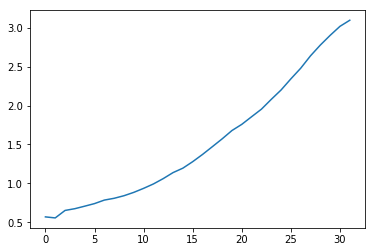

In [16]:
C_corrvariance.plot.line()

From the graph, we can assume $\frac{\Delta C(t)}{\bar{C}(t)}$ is approximately a quadratic function of $t$. And do fitting.

In [17]:
fit_function = np.poly1d(np.polyfit(list(range(32)),
                                    list(C_corrvariance), 2))
print(fit_function)

          2
0.002263 x + 0.01321 x + 0.5904


The following graph shows that it fits well.

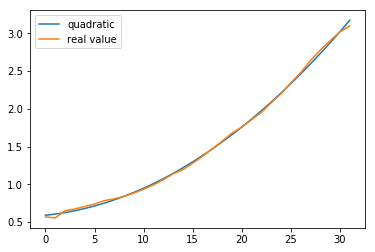

In [18]:
x = np.linspace(0, 31, 100)
plt.plot(x, fit_function(x), label='quadratic')
C_corrvariance.plot.line(label='real value')
plt.legend()

### (b) Construct $m_{eff}(t)$.

Compute $m_{eff}(t)$ according to the formula.

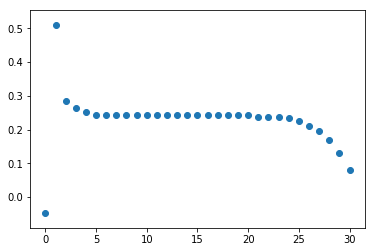

In [19]:
m_eff_values = pd.Series([np.log(C_mean[t] / C_mean[t+1]) for t in range(31)])
plt.scatter(range(31), m_eff_values)

Use Jackknife to get $\Delta m(t)$.

In [20]:
elim_C_means = dict()

for t in range(32):
    C_t_sum = sum(df[t])
    elim_C_t_means = [(C_t_sum - float(df.loc[i, [t]])) / 199
                      for i in range(200)]
    #print('elim_C_' + str(t) + '_means is computed.')
    elim_C_means[t] = np.array(elim_C_t_means)

In [21]:
elim_m_eff = np.array([np.log(elim_C_means[t] / elim_C_means[t+1]) 
                       for t in range(31)])

m_eff_error = np.array([np.sqrt(199 / 200
                                * sum((elim_m_eff[t] - m_eff_values[t]) ** 2))
                        for t in range(31)])

(0, 0.005)

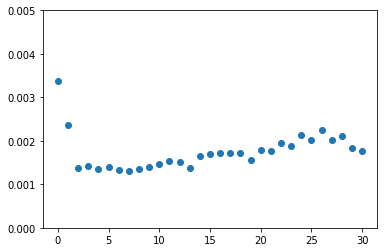

In [22]:
plt.scatter(range(31), pd.Series(m_eff_error))
plt.ylim(0, 5e-3)

### (c) $\chi^2$ fit $m$.

Algorithm to find $\min{\chi^2}\big|_{t_{min}, t_{max}}$, given $t_{min}, t_{max}$.

In [23]:
def min_square_chi(t_min, t_max):
    m = (sum(m_eff_values[t_min : t_max+1]
             / m_eff_error[t_min : t_max+1] ** 2)
         / sum(1 / m_eff_error[t_min : t_max+1] ** 2))
    square_chi = sum(((m_eff_values[t_min : t_max+1] - m)
                      / m_eff_error[t_min : t_max+1]) ** 2)
    return square_chi, m

min_square_chi(6, 10)

(2.2873021154577824, 0.24311395394571522)

Find $t_{min}, t_{max}$ to minimize $\min{\chi^2}\big|_{t_{min}, t_{max}}$.

In [24]:
square_chi_fit, m_fit = 0, 0
t_min_fit, t_max_fit = 0, 0
min_divided_square_chi = np.inf

for t_min in range(0, 29):
    for t_max in range(t_min+3, 32):
        d = t_max - t_min
        current_square_chi, current_m = min_square_chi(t_min, t_max)
        if current_square_chi / d < min_divided_square_chi:
            min_divided_square_chi = current_square_chi / d
            square_chi_fit, m_fit = current_square_chi, current_m
            t_min_fit, t_max_fit = t_min, t_max

print('t_min_fit=', t_min_fit)
print('t_max_fit=', t_max_fit)
print('square_chi_fit=', square_chi_fit)
print('m_fit=', m_fit)

t_min_fit= 12
t_max_fit= 15
square_chi_fit= 0.2987680410979604
m_fit= 0.2433163107965347


In [25]:
m_fit_error = 1\
/ np.sqrt(sum(1 / m_eff_error[t_min_fit : t_max_fit+1] ** 2))

Latex(r'$m\pm\delta m = %.5f\pm%.5f$' % (m_fit, m_fit_error))

<IPython.core.display.Latex object>

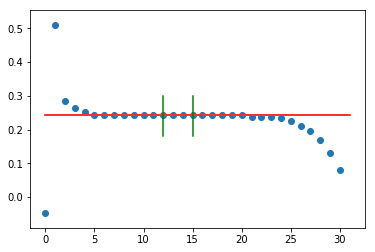

In [26]:
m_eff = pd.Series([np.log(C_mean[t] / C_mean[t+1])
                   for t in range(31)])
plt.scatter(range(31), m_eff)
plt.plot([0, 31], [m_fit+m_fit_error]*2, color='pink')
plt.plot([0, 31], [m_fit-m_fit_error]*2, color='pink')
plt.plot([0, 31], [m_fit]*2, color='r')
plt.plot([t_min_fit]*2, [0.18, 0.30], color='g')
plt.plot([t_max_fit]*2, [0.18, 0.30], color='g')

(0.24176662065865026, 0.24486600093441915)

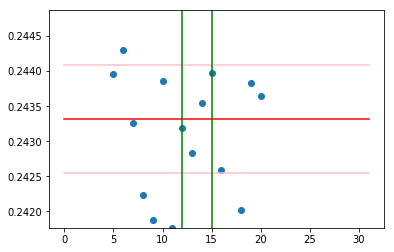

In [27]:
plt.scatter(range(31), m_eff)
plt.plot([0, 31], [m_fit]*2, color='r')
plt.plot([0, 31], [m_fit+m_fit_error]*2, color='pink')
plt.plot([0, 31], [m_fit-m_fit_error]*2, color='pink')
plt.plot([t_min_fit]*2, [m_fit - 2*m_fit_error, m_fit + 2*m_fit_error], color='g')
plt.plot([t_max_fit]*2, [m_fit - 2*m_fit_error, m_fit + 2*m_fit_error], color='g')
plt.ylim(m_fit - 2*m_fit_error, m_fit + 2*m_fit_error)

Compute p-value.

In [28]:
p = 1 - (1 / gamma(3/2)) * quad(lambda t: np.exp(-t) * pow(t, 1/2),
                                square_chi_fit / 2, np.inf)[0]
Latex(r'$P=%.4f$' % p)

<IPython.core.display.Latex object>

### (d) $\chi^2$ fit $\tilde{m}$.

$\tilde{m}_{eff}(t=1)$ is pure imaginary. So $t$ start from $2$.

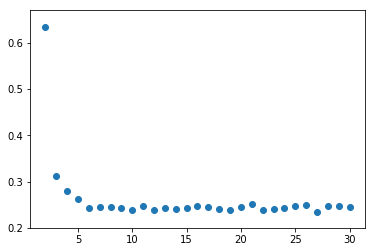

In [29]:
m_eff_wave = pd.Series([np.nan]*2
                       + [np.arccosh((C_mean[t+1] + C_mean[t-1])
                                     / 2 / C_mean[t])
                        for t in range(2, 31)])
plt.scatter(range(31), m_eff_wave)

In [30]:
elim_m_eff_wave = np.array(np.r_[[np.nan] * np.ones([2, 200]),
                           [np.arccosh((elim_C_means[t+1]
                                        + elim_C_means[t-1])
                                       / 2 / elim_C_means[t])
                           for t in range(2, 31)]])


m_eff_wave_error = np.array([np.sqrt(199 / 200 
                                     * sum((elim_m_eff_wave[i]
                                            - m_eff_wave[i]) ** 2))
                        for i in range(31)])

m_eff_wave_error

array([       nan,        nan, 0.00300393, 0.00341165, 0.00347849,
       0.00327695, 0.00390736, 0.00373815, 0.0034596 , 0.00362766,
       0.00406958, 0.00366334, 0.00360251, 0.00371569, 0.00335503,
       0.00385881, 0.00405461, 0.00390396, 0.00360781, 0.00403982,
       0.00364246, 0.0037553 , 0.00427342, 0.00452456, 0.00360195,
       0.00406191, 0.00367437, 0.00453883, 0.00385287, 0.00388379,
       0.00385959])

(0, 0.01979217814390574)

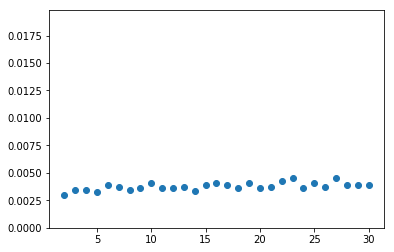

In [31]:
plt.scatter(range(31), pd.Series(m_eff_wave_error))
plt.ylim(0)

Do the same thing in section (c).

In [32]:
def min_square_chi_wave(t_min, t_max):
    m = (sum(m_eff_wave[t_min : t_max+1]
             / m_eff_wave_error[t_min : t_max+1] ** 2)
         / sum(1 / m_eff_wave_error[t_min : t_max+1] ** 2))
    square_chi = sum(((m_eff_wave[t_min : t_max+1] - m)
                      / m_eff_wave_error[t_min : t_max+1]) ** 2)
    return square_chi, m

min_square_chi_wave(6, 10)

(2.0290706797631874, 0.24333829136693813)

In [33]:
square_chi_wave_fit, m_eff_wave_fit = 0, 0
t_min_wave_fit, t_max_wave_fit = 0, 0
min_divided_square_chi = float('inf')

for t_min in range(2, 28):
    for t_max in range(t_min+3, 31):
        d = t_max - t_min
        current_square_chi, current_m = min_square_chi_wave(t_min, t_max)
        if current_square_chi / d < min_divided_square_chi:
            min_divided_square_chi = current_square_chi / d
            square_chi_wave_fit, m_wave_fit = current_square_chi, current_m
            t_min_wave_fit, t_max_wave_fit = t_min, t_max

print('t_min_wave_fit=', t_min_wave_fit)
print('t_max_wave_fit=', t_max_wave_fit)
print('square_chi_wave_fit=', square_chi_wave_fit)
print('m_wave_fit=', m_wave_fit)

t_min_wave_fit= 6
t_max_wave_fit= 9
square_chi_wave_fit= 0.44663660415391415
m_wave_fit= 0.24428825032326718


In [34]:
m_wave_fit_error = 1\
/ np.sqrt(sum(1 / m_eff_wave_error[t_min_wave_fit : t_max_wave_fit+1] ** 2))

Latex(r'$\tilde{m} \pm \delta\tilde{m} = %.5f\pm%.5f$'
      % (m_wave_fit, m_wave_fit_error))

<IPython.core.display.Latex object>

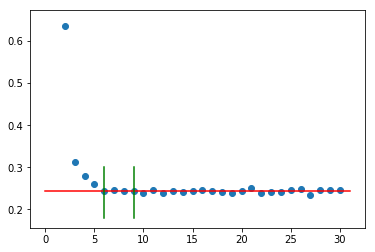

In [35]:
plt.scatter(range(31), m_eff_wave)
plt.plot([0, 31], [m_wave_fit]*2, color='r')
plt.plot([t_min_wave_fit]*2, [0.18, 0.30], color='g')
plt.plot([t_max_wave_fit]*2, [0.18, 0.30], color='g')

(0.24061589917036189, 0.24796060147617247)

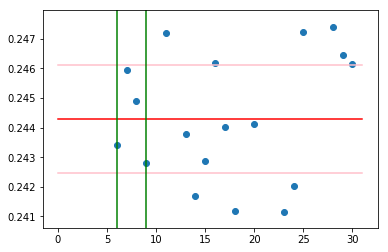

In [36]:
plt.scatter(range(31), m_eff_wave)
plt.plot([0, 31], [m_wave_fit]*2, color='r')
plt.plot([0, 31], [m_wave_fit+m_wave_fit_error]*2, color='pink')
plt.plot([0, 31], [m_wave_fit-m_wave_fit_error]*2, color='pink')
plt.plot([t_min_wave_fit]*2, [m_wave_fit  - 2*m_wave_fit_error,
                              m_wave_fit + 2*m_wave_fit_error], color='g')
plt.plot([t_max_wave_fit]*2, [m_wave_fit - 2*m_wave_fit_error,
                              m_wave_fit + 2*m_wave_fit_error], color='g')
plt.ylim(m_wave_fit - 2*m_wave_fit_error,
        m_wave_fit + 2*m_wave_fit_error)

In [37]:
p = 1 - (1 / gamma(3/2)) * quad(lambda t: np.exp(-t) * pow(t, 1/2),
       square_chi_wave_fit / 2, np.inf)[0]

Latex(r'$P=%.4f$' % p)

<IPython.core.display.Latex object>

### (e) correlation matrix

Construct covariance matrix given a dataframe.

In [38]:
def covariance_matrix(df):
    mean_values = df.mean(axis=0)
    return (np.matrix((df - mean_values)).T
            * np.matrix(df - mean_values) /
            (df.shape[0] - 1))

Construct 1000 bootstrap samples as dataframes and compute their $\rho_{3,4}$ and $\rho_{3,5}$. It'll cost a little bit long time.

In [39]:
bootstrap_rou34 = []
bootstrap_rou35 = []

for times in range(1000):
    bootstrap_df = pd.DataFrame(None, columns=list(range(32)))
    for i in np.random.randint(0, 200, 200):
        bootstrap_df = bootstrap_df.append(df.loc[i])
    cm = covariance_matrix(bootstrap_df)
    bootstrap_rou34.append(cm[3, 4] / np.sqrt(cm[3, 3] * cm[4, 4]))
    bootstrap_rou35.append(cm[3, 5] / np.sqrt(cm[3, 3] * cm[5, 5]))
    if times % 100 == 0:
        print('times:', times, 'bootstrap done.')

times: 0 bootstrap done.
times: 100 bootstrap done.
times: 200 bootstrap done.
times: 300 bootstrap done.
times: 400 bootstrap done.
times: 500 bootstrap done.
times: 600 bootstrap done.
times: 700 bootstrap done.
times: 800 bootstrap done.
times: 900 bootstrap done.


Compute center value of $\rho_{3,4}$ and error $\delta\rho_{3,4}$.

In [40]:
rou34_center = np.mean(bootstrap_rou34)

In [41]:
sorted_bootstrap_rou34 = sorted(bootstrap_rou34)
rou34_down = sorted_bootstrap_rou34[160]
rou34_center - rou34_down

0.0032090331021192853

In [42]:
rou34_up = sorted_bootstrap_rou34[840-1]
rou34_up - rou34_center

0.003163074399061938

In [43]:
(rou34_up - rou34_down) / 2

0.0031860537505906117

In [44]:
Latex(r'$\rho_{3,4}\pm\delta\rho_{3,4}=%.3f\pm%.3f$'
      % (rou34_center, (rou34_up - rou34_down) / 2))

<IPython.core.display.Latex object>

Do the same statics to $\rho_{3,5}$

In [45]:
rou35_center = np.mean(bootstrap_rou35)
rou35_center

0.9577024048830498

In [46]:
sorted_bootstrap_rou35 = sorted(bootstrap_rou35)
rou35_down = sorted_bootstrap_rou35[160]
rou35_down - rou35_center

-0.005871072732161475

In [47]:
rou35_up = sorted_bootstrap_rou35[840-1]
rou35_up - rou35_down

0.011716828154024195

In [48]:
(rou35_up - rou35_down) / 2

0.005858414077012097

In [49]:
Latex(r'$\rho_{3,5}\pm\delta\rho_{3,5}=%.3f\pm%.3f$'
      % (rou35_center, (rou35_up - rou35_down) / 2))

<IPython.core.display.Latex object>